In [1]:
import sys

sys.path.append("..")

from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data

data = data[
    data["brand"].isin(["brand-35", "brand-14", "brand-15"])
] # Filtramos las 3 brands principales únicamente

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def regression_with_backward_elimination(
    data: pd.DataFrame,
    target: str = "volume.sales",
    alpha: float = 0.05,
    verbose: bool = False,
) -> tuple:
    """
    Realiza regresión OLS con backward elimination automática.

    Elimina automáticamente las variables no significativas (p-valor > alpha)
    del modelo de regresión.

    El modelo incluye:
    - Variables lineales: price, supermarket (dummy), variant (dummy), 
      pack_size (dummy), brand (dummy)
    - Interacciones solo entre price y brand (hasta segundo grado):
      price * brand, price**2, price**2 * brand

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame con los datos. Debe contener las columnas: price, supermarket,
        variant, pack.size, brand, y la columna target.
    target : str, default="volume.sales"
        Nombre de la columna objetivo (variable dependiente).
    alpha : float, default=0.05
        Nivel de significancia para eliminar variables. Variables con p-valor > alpha
        serán eliminadas.
    verbose : bool, default=False
        Si True, muestra el progreso de eliminación de variables.

    Returns:
    --------
    tuple:
        - model: Modelo final de statsmodels después de backward elimination
        - selected_vars: Lista de variables seleccionadas (nombres de columnas)
        - eliminated_vars: Lista de variables eliminadas durante el proceso

    Example:
    --------
    >>> model, selected, eliminated = regression_with_backward_elimination(data)
    >>> print(f"Variables seleccionadas: {len(selected)}")
    >>> print(f"Variables eliminadas: {len(eliminated)}")
    """
    # Hacer una copia para no modificar el DataFrame original
    data_work = data.copy()

    # Renombrar columnas para compatibilidad con patsy (puntos → guiones bajos)
    rename_dict = {
        "value.sales": "value_sales",
        "unit.sales": "unit_sales",
        "volume.sales": "volume_sales",
        "pack.size": "pack_size",
    }

    # Solo renombrar las columnas que existen
    rename_dict = {k: v for k, v in rename_dict.items() if k in data_work.columns}
    data_work.rename(columns=rename_dict, inplace=True)

    # Actualizar el nombre del target si fue renombrado
    target_renamed = rename_dict.get(target, target)

    # Crear fórmula con:
    # - Términos lineales: price, supermarket, variant, pack_size, brand
    # - Interacciones solo entre price y brand (hasta segundo grado)
    formule = (
        f"{target_renamed} ~ price + C(supermarket) + C(variant) + C(pack_size) + "
        f"C(brand) + (price + C(brand)) ** 2"
    )

    # Crear matrices de diseño usando patsy
    y, X = patsy.dmatrices(formule, data=data_work, return_type="dataframe")
    
    # Guardar todas las variables iniciales
    initial_vars = set(X.columns.tolist())

    # Nombres posibles de constante/intercepto
    CONST_CANDIDATES = [c for c in ["const", "Intercept"] if c in X.columns]

    # Lista para rastrear variables eliminadas
    eliminated_vars = []

    # Backward elimination
    iteration = 0
    while True:
        iteration += 1

        # Ajustar el modelo OLS
        model = sm.OLS(y, X).fit()

        # Obtener p-valores excluyendo la constante/intercepto
        pvals = model.pvalues.copy()
        for c in CONST_CANDIDATES:
            if c in pvals.index:
                pvals = pvals.drop(c)

        # Si no hay más variables (solo queda la constante), terminar
        if pvals.empty:
            if verbose:
                print("No quedan variables para eliminar (solo constante).")
            break

        # Encontrar el p-valor máximo
        max_p = pvals.max()

        # Si el p-valor máximo es mayor que alpha, eliminar esa variable
        if max_p > alpha:
            worst_var = pvals.idxmax()  # Nombre de la variable con mayor p-valor

            if verbose:
                print(
                    f"Iteración {iteration}: Eliminando '{worst_var}' (p-valor = {max_p:.4f})"
                )

            # Eliminar la variable por nombre
            X = X.drop(columns=[worst_var])
            eliminated_vars.append(worst_var)
        else:
            # Todas las variables restantes son significativas
            if verbose:
                print(
                    f"Iteración {iteration}: Todas las variables restantes son significativas (p-valor ≤ {alpha})"
                )
            break

    # Ajustar el modelo final con las variables seleccionadas
    final_model = sm.OLS(y, X).fit()

    # Obtener las variables seleccionadas
    selected_vars = X.columns.tolist()

    if verbose:
        print(f"\nResumen:")
        print(f"  Variables iniciales: {len(initial_vars)}")
        print(f"  Variables seleccionadas: {len(selected_vars)}")
        print(f"  Variables eliminadas: {len(eliminated_vars)}")
        print(f"  R² ajustado: {final_model.rsquared_adj:.4f}")

    return final_model, selected_vars, eliminated_vars

In [3]:
model, selected_var, deleted_var = regression_with_backward_elimination(data, verbose=True)
print(model.summary())

Iteración 1: Eliminando 'price:C(brand)[T.brand-15]' (p-valor = 0.9778)
Iteración 2: Eliminando 'price' (p-valor = 0.0895)
Iteración 3: Todas las variables restantes son significativas (p-valor ≤ 0.05)

Resumen:
  Variables iniciales: 15
  Variables seleccionadas: 13
  Variables eliminadas: 2
  R² ajustado: 0.4307
                            OLS Regression Results                            
Dep. Variable:           volume_sales   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     215.4
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:36:30   Log-Likelihood:                -41082.
No. Observations:                3403   AIC:                         8.219e+04
Df Residuals:                    3390   BIC:                         8.227e+04
Df Model:                          12               

In [6]:
def x_train_exog_custom(train_data, selected_columns, model, target="volume.sales"):
    """
    Prepara las variables exógenas usando la misma fórmula que regression_with_backward_elimination.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Datos de entrenamiento
    selected_columns : list
        Lista de columnas seleccionadas por backward elimination
    model : statsmodels model
        Modelo ajustado
    target : str
        Nombre de la columna objetivo
        
    Returns:
    --------
    X_train_exog : pd.DataFrame
        DataFrame con las variables exógenas seleccionadas
    """
    train_data_for_patsy = train_data.copy()
    
    # Renombrar columnas para compatibilidad con patsy
    rename_dict = {
        "value.sales": "value_sales",
        "unit.sales": "unit_sales",
        "volume.sales": "volume_sales",
        "pack.size": "pack_size",
    }
    rename_dict = {k: v for k, v in rename_dict.items() if k in train_data_for_patsy.columns}
    train_data_for_patsy.rename(columns=rename_dict, inplace=True)
    
    # Actualizar el nombre del target si fue renombrado
    target_renamed = rename_dict.get(target, target)
    
    # Usar la MISMA fórmula que en regression_with_backward_elimination
    formula = (
        f"{target_renamed} ~ price + C(supermarket) + C(variant) + C(pack_size) + "
        f"C(brand) + (price + C(brand)) ** 2"
    )
    
    # Crear la matriz de diseño
    y_design, X_design = patsy.dmatrices(
        formula, data=train_data_for_patsy, return_type="dataframe"
    )
    
    # Filtrar solo las columnas seleccionadas (excluyendo Intercept)
    selected_columns_no_intercept = [
        col for col in selected_columns if col != "Intercept" and col != "const"
    ]
    
    # Verificar que las columnas existen
    missing_cols = [col for col in selected_columns_no_intercept if col not in X_design.columns]
    if missing_cols:
        print(f"⚠️ Advertencia: Las siguientes columnas no se encontraron en X_design: {missing_cols}")
        print(f"Columnas disponibles en X_design: {list(X_design.columns)}")
        # Filtrar solo las que existen
        selected_columns_no_intercept = [
            col for col in selected_columns_no_intercept if col in X_design.columns
        ]
    
    X_train_exog = X_design[selected_columns_no_intercept]
    
    # Verificar que coinciden con el modelo
    model_features = list(model.params.index)
    exog_features = list(X_train_exog.columns)
    
    model_features_no_intercept = [f for f in model_features if f not in ["Intercept", "const"]]
    if set(model_features_no_intercept) == set(exog_features):
        print("✅ YES - All features match perfectly!")
    else:
        print("❌ NO - Features don't match")
        print(f"Model features (sin intercept): {sorted(model_features_no_intercept)}")
        print(f"Exog features: {sorted(exog_features)}")
        missing_in_exog = set(model_features_no_intercept) - set(exog_features)
        missing_in_model = set(exog_features) - set(model_features_no_intercept)
        if missing_in_exog:
            print(f"Missing in exog: {missing_in_exog}")
        if missing_in_model:
            print(f"Missing in model: {missing_in_model}")
    
    return X_train_exog

# Usar la nueva función
X_train_exog = x_train_exog_custom(data, selected_var, model)
print(f"\nShape de X_train_exog: {X_train_exog.shape}")
print(f"Columnas: {list(X_train_exog.columns)}")
print('#'*20)
print(pd.Series(X_train_exog.columns, name='X_train_exog_columns'))

✅ YES - All features match perfectly!

Shape de X_train_exog: (3403, 12)
Columnas: ['C(supermarket)[T.supermarket-B]', 'C(supermarket)[T.supermarket-C]', 'C(supermarket)[T.supermarket-D]', 'C(variant)[T.light]', 'C(variant)[T.standard]', 'C(variant)[T.vegan]', 'C(pack_size)[T.351 - 500 GR]', 'C(pack_size)[T.501 - 700 GR]', 'C(pack_size)[T.701 - 1000 GR]', 'C(brand)[T.brand-15]', 'C(brand)[T.brand-35]', 'price:C(brand)[T.brand-35]']
####################
0     C(supermarket)[T.supermarket-B]
1     C(supermarket)[T.supermarket-C]
2     C(supermarket)[T.supermarket-D]
3                 C(variant)[T.light]
4              C(variant)[T.standard]
5                 C(variant)[T.vegan]
6        C(pack_size)[T.351 - 500 GR]
7        C(pack_size)[T.501 - 700 GR]
8       C(pack_size)[T.701 - 1000 GR]
9                C(brand)[T.brand-15]
10               C(brand)[T.brand-35]
11         price:C(brand)[T.brand-35]
Name: X_train_exog_columns, dtype: object


In [8]:
X_train_exogs = sa.x_train_exog(data, selected_var, model, aggregation="none")
print(f"\nShape de X_train_exog: {X_train_exog.shape}")
print("Columnas:")
for col in X_train_exog.columns:
    print(col)


✅ YES - All features match perfectly!

Shape de X_train_exog: (3403, 12)
Columnas:
C(supermarket)[T.supermarket-B]
C(supermarket)[T.supermarket-C]
C(supermarket)[T.supermarket-D]
C(variant)[T.light]
C(variant)[T.standard]
C(variant)[T.vegan]
C(pack_size)[T.351 - 500 GR]
C(pack_size)[T.501 - 700 GR]
C(pack_size)[T.701 - 1000 GR]
C(brand)[T.brand-15]
C(brand)[T.brand-35]
price:C(brand)[T.brand-35]


In [9]:
#compare X_train_exog and X_train_exogs
print(X_train_exog.equals(X_train_exogs))

True


### Implementación 1: transformación **Logatítmica**

In [10]:
# ========== TRANSFORMACIÓN LOGARÍTMICA DE LA VARIABLE OBJETIVO ==========
# Verificar que volume.sales sea positiva para aplicar log
y_original = data['volume.sales'].copy()

print("📊 Verificación de datos para transformación logarítmica:")
print(f"   - Longitud de datos: {len(y_original)}")
print(f"   - Valor mínimo: {y_original.min():.6f}")
print(f"   - Valor máximo: {y_original.max():.6f}")
print(f"   - Valores <= 0: {(y_original <= 0).sum()}")
print(f"   - Media: {y_original.mean():.2f}")

# Decidir el método de transformación
if (y_original <= 0).any():
    # Si hay ceros o negativos, usar log(y + constante)
    min_positive = y_original[y_original > 0].min() if (y_original > 0).any() else 1.0
    constant = max(1.0, min_positive)
    y_log = np.log(y_original + constant)
    transformation_type = 'log_shift'
    transformation_constant = constant
    print(f"   ⚠️  Se detectaron valores <= 0. Usando log(y + {constant:.6f})")
else:
    # Si todos son positivos, usar log simple
    y_log = np.log(y_original)
    transformation_type = 'log'
    transformation_constant = 0.0
    print(f"   ✅ Todos los valores son positivos. Usando log(y)")

print(f"\n📈 Estadísticas después de la transformación:")
print(f"   - Media log: {y_log.mean():.6f}")
print(f"   - Desviación estándar log: {y_log.std():.6f}")
print(f"   - Tipo de transformación: {transformation_type}")

# Guardar información de la transformación para reversión futura
transformation_info = {
    'type': transformation_type,
    'constant': transformation_constant
}



📊 Verificación de datos para transformación logarítmica:
   - Longitud de datos: 3403
   - Valor mínimo: 0.165000
   - Valor máximo: 539900.600000
   - Valores <= 0: 0
   - Media: 36600.34
   ✅ Todos los valores son positivos. Usando log(y)

📈 Estadísticas después de la transformación:
   - Media log: 8.782770
   - Desviación estándar log: 3.106810
   - Tipo de transformación: log


In [11]:
print("=" * 60)
print("PROBANDO AUTO_ARIMA CON VARIABLES LIMPIAS")
print("=" * 60)

auto_arima_model_clean = auto_arima( 
    y=y_log,
    X=X_train_exog,  # Usar las variables limpias
    start_p=0,
    d=0,  
    start_q=0,
    max_p=3,  # Puedes aumentar esto si quieres probar más modelos
    max_q=3,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  # Usar stepwise=True para ser más eficiente
    n_fits=50,  # Número de ajustes a probar
    information_criterion='aic'
)

PROBANDO AUTO_ARIMA CON VARIABLES LIMPIAS
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=18855.350, Time=0.59 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=17841.499, Time=100.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=138.89 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=18853.350, Time=2.78 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=18857.211, Time=1.28 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=215.26 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=137.76 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=17839.499, Time=94.44 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=205.74 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=134.37 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=17841.499, Time=100.58 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=17843.499, Time=131.10 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=17837.502, Time=468.04 sec
 ARIMA(0,0,0)(1,1,1)[12]             : AIC

-----------------Residues Analysis (White Noise) -----------------
[Heteroscedasticity Test] ARCH p-value: 0.8760245563485528 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 1.4548666245845683e-178 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 7.04853588743164e-36 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
      lb_stat  lb_pvalue
10  6.167492      0.801 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 1.958625498564637 -- range(2.0)
------------------------------------------------------------------


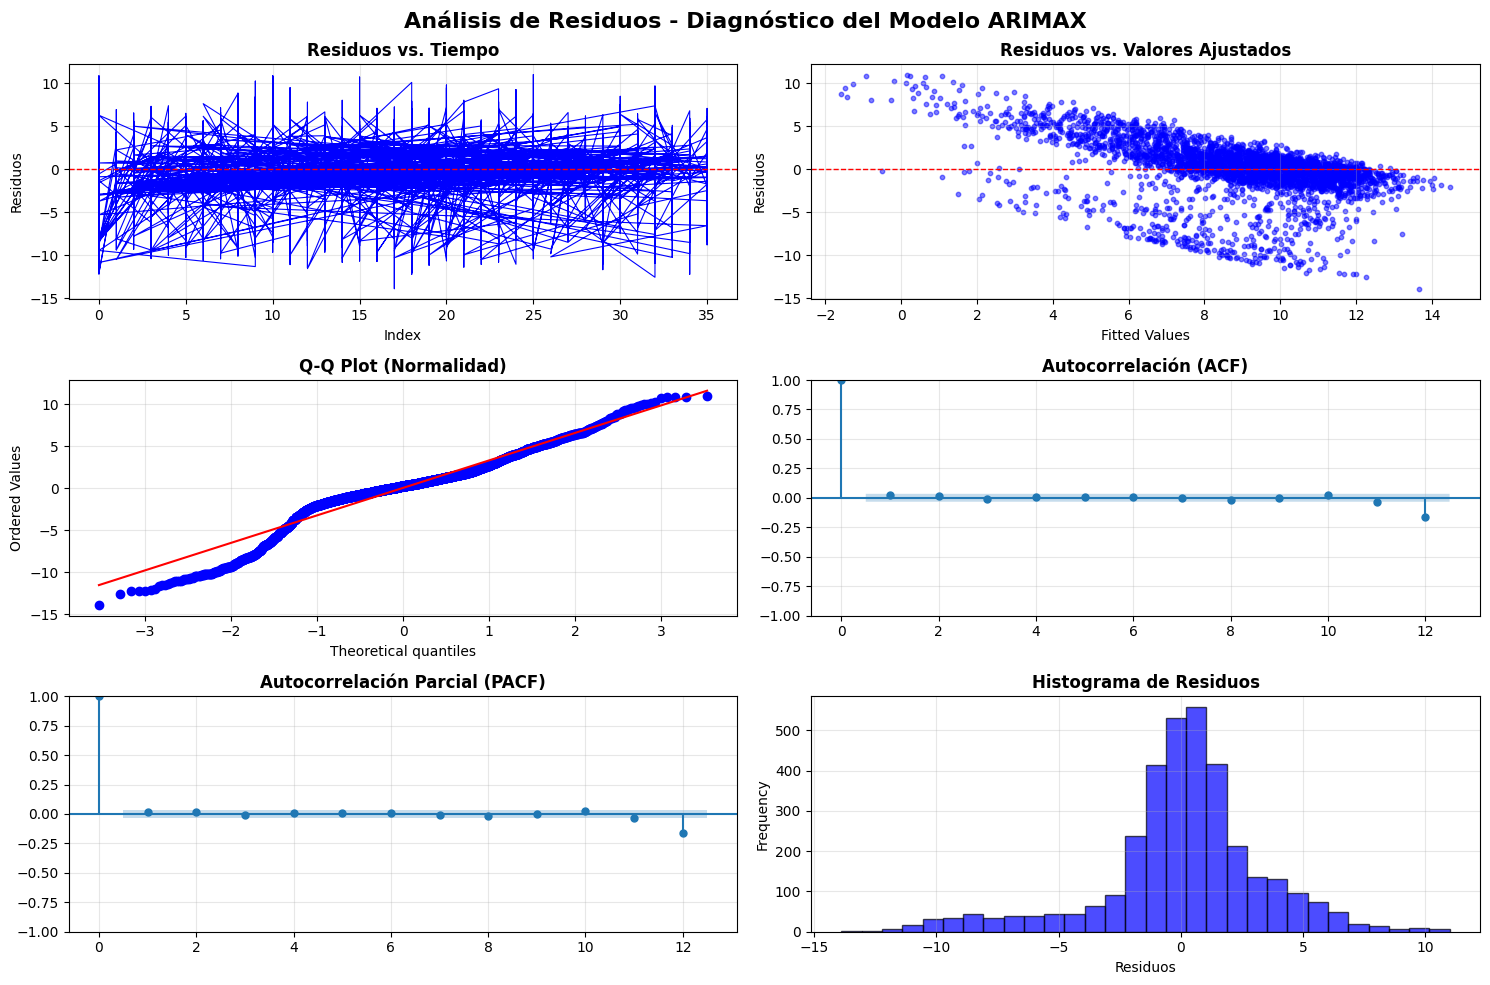

In [12]:
from scipy import stats
# Análisis de residuos

residuals = auto_arima_model_clean.arima_res_.resid

print("-----------------Residues Analysis (White Noise) -----------------")
sa.residual_white_noise_test(residuals)
print("------------------------------------------------------------------") 

# ========== GRÁFICO DE DIAGNÓSTICO DE RESIDUOS ==========

# Obtener residuos y valores ajustados
residuals = auto_arima_model_clean.arima_res_.resid
fitted_values = auto_arima_model_clean.arima_res_.fittedvalues

# Crear figura con 6 subplots (3 filas x 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Análisis de Residuos - Diagnóstico del Modelo ARIMAX', fontsize=16, fontweight='bold')

# 1. Residuos vs. Tiempo (arriba-izquierda)
axes[0, 0].plot(residuals, color='blue', linewidth=0.8)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuos vs. Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuos vs. Valores Ajustados (arriba-derecha)
axes[0, 1].scatter(fitted_values, residuals, alpha=0.5, s=10, color='blue')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_title('Residuos vs. Valores Ajustados', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (medio-izquierda)
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF (Autocorrelación) (medio-derecha)
plot_acf(residuals, lags=12, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Autocorrelación (ACF)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 5. PACF (Autocorrelación Parcial) (abajo-izquierda)
plot_pacf(residuals, lags=12, ax=axes[2, 0], alpha=0.05, method='ywm')
axes[2, 0].set_title('Autocorrelación Parcial (PACF)', fontsize=12, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# 6. Histograma de Residuos (abajo-derecha)
axes[2, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[2, 1].set_title('Histograma de Residuos', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Residuos')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Implementación 2: transformación **Box-Cox**

In [13]:
# ========== TRANSFORMACIÓN BOX-COX DE LA VARIABLE OBJETIVO ==========
# Verificar que volume.sales sea positiva para aplicar Box-Cox
y_original_bc = data['volume.sales'].copy()

print("📊 Verificación de datos para transformación Box-Cox:")
print(f"   - Longitud de datos: {len(y_original_bc)}")
print(f"   - Valor mínimo: {y_original_bc.min():.6f}")
print(f"   - Valor máximo: {y_original_bc.max():.6f}")
print(f"   - Valores <= 0: {(y_original_bc <= 0).sum()}")
print(f"   - Media: {y_original_bc.mean():.2f}")

# Box-Cox requiere valores estrictamente positivos
if (y_original_bc <= 0).any():
    # Si hay ceros o negativos, necesitamos hacer un shift
    min_positive = y_original_bc[y_original_bc > 0].min() if (y_original_bc > 0).any() else 1.0
    constant = max(1.0, min_positive)
    y_shifted = y_original_bc + constant
    print(f"   ⚠️  Se detectaron valores <= 0. Aplicando shift: y + {constant:.6f}")
else:
    y_shifted = y_original_bc.copy()
    constant = 0.0
    print(f"   ✅ Todos los valores son positivos. No se requiere shift")

# Aplicar transformación Box-Cox
# scipy.stats.boxcox encuentra el lambda óptimo y aplica la transformación
y_boxcox, lambda_optimal = stats.boxcox(y_shifted)

print(f"\n📈 Estadísticas después de la transformación Box-Cox:")
print(f"   - Lambda óptimo: {lambda_optimal:.6f}")
print(f"   - Media Box-Cox: {y_boxcox.mean():.6f}")
print(f"   - Desviación estándar Box-Cox: {y_boxcox.std():.6f}")
print(f"   - Constante de shift aplicada: {constant:.6f}")

# Guardar información de la transformación para reversión futura
boxcox_transformation_info = {
    'type': 'boxcox',
    'lambda': lambda_optimal,
    'constant': constant
}

# Nota: Para revertir la transformación Box-Cox:
# y_reversed = np.power(y_boxcox * lambda_optimal + 1, 1/lambda_optimal) - constant
# Si lambda_optimal == 0, entonces: y_reversed = np.exp(y_boxcox) - constant


📊 Verificación de datos para transformación Box-Cox:
   - Longitud de datos: 3403
   - Valor mínimo: 0.165000
   - Valor máximo: 539900.600000
   - Valores <= 0: 0
   - Media: 36600.34
   ✅ Todos los valores son positivos. No se requiere shift

📈 Estadísticas después de la transformación Box-Cox:
   - Lambda óptimo: 0.221782
   - Media Box-Cox: 32.753729
   - Desviación estándar Box-Cox: 16.377705
   - Constante de shift aplicada: 0.000000


In [14]:
print("=" * 60)
print("PROBANDO AUTO_ARIMA CON TRANSFORMACIÓN BOX-COX")
print("=" * 60)

auto_arima_model_boxcox = auto_arima( 
    y=y_boxcox,
    X=X_train_exog,  # Usar las variables limpias
    start_p=0,
    d=0,  
    start_q=0,
    max_p=3,  # Puedes aumentar esto si quieres probar más modelos
    max_q=3,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  # Usar stepwise=True para ser más eficiente
    n_fits=50,  # Número de ajustes a probar
    information_criterion='aic'
)


PROBANDO AUTO_ARIMA CON TRANSFORMACIÓN BOX-COX
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=29273.054, Time=0.50 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=28272.393, Time=188.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=129.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=29271.054, Time=2.52 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=29273.788, Time=1.59 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=129.21 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=127.36 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=28270.887, Time=95.34 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=122.29 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=83.04 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=28272.458, Time=207.93 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=28274.364, Time=197.63 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=28268.878, Time=157.18 sec
 ARIMA(0,0,0)(1,1,1)[12]             :

-----------------Residues Analysis (White Noise) - Box-Cox -----------------
[Heteroscedasticity Test] ARCH p-value: 0.7034787992778437 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 7.925822199046298e-38 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 1.6452917342222447e-20 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
      lb_stat  lb_pvalue
10  6.921181   0.732864 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 2.0073103032585897 -- range(2.0)
------------------------------------------------------------------


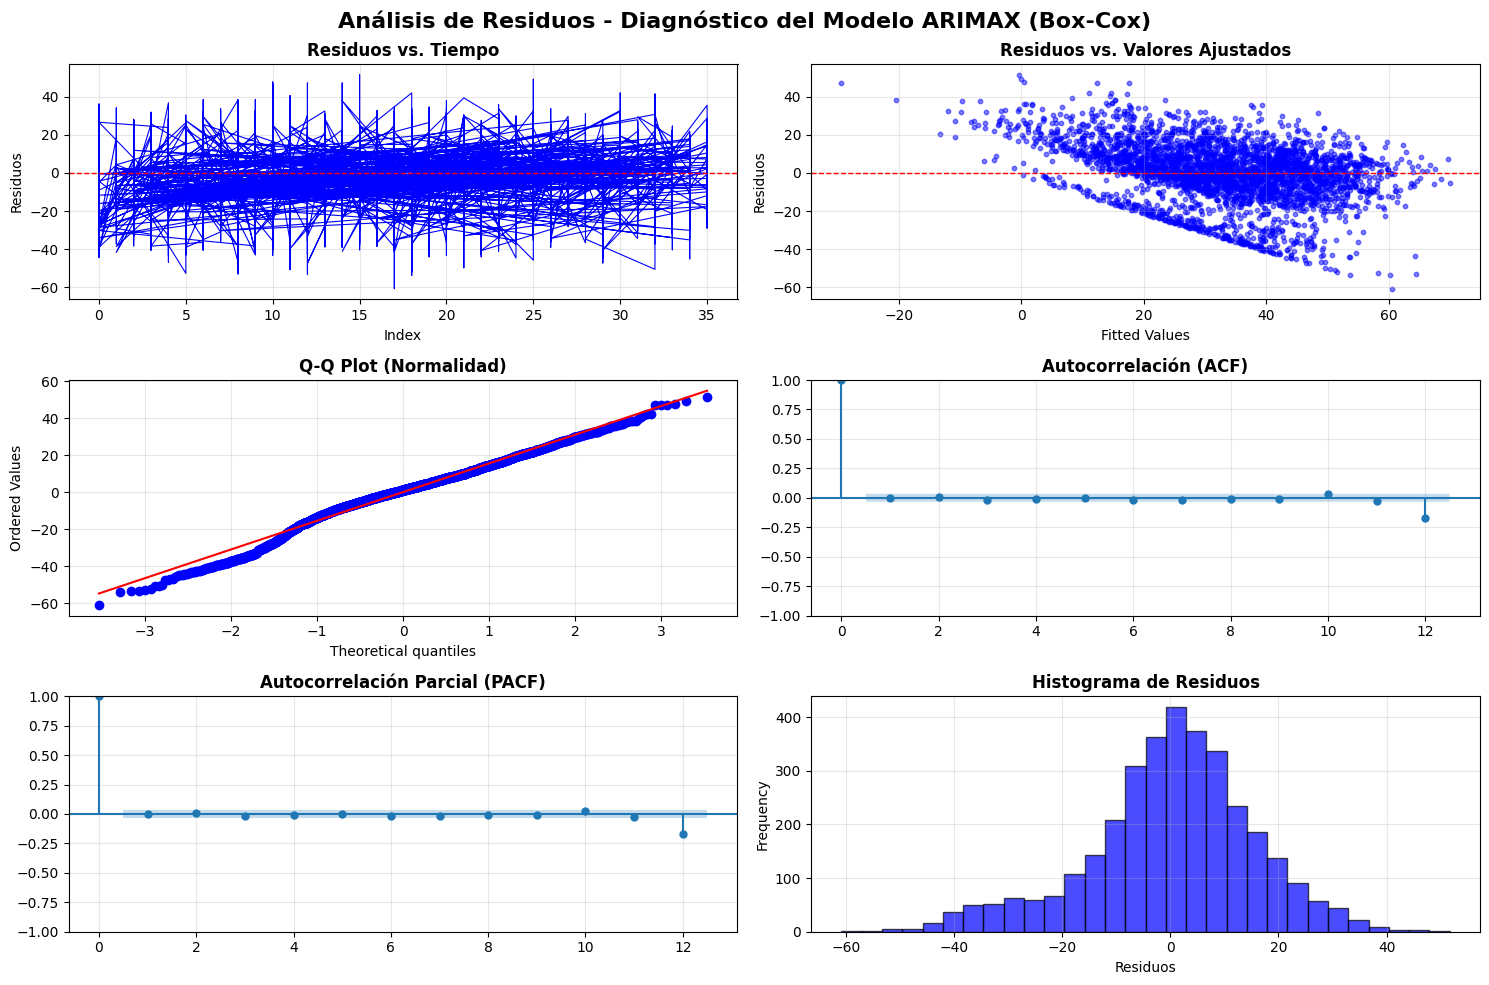

In [15]:
# Análisis de residuos para modelo Box-Cox

residuals_boxcox = auto_arima_model_boxcox.arima_res_.resid

print("-----------------Residues Analysis (White Noise) - Box-Cox -----------------")
sa.residual_white_noise_test(residuals_boxcox)
print("------------------------------------------------------------------") 

# ========== GRÁFICO DE DIAGNÓSTICO DE RESIDUOS ==========

# Obtener residuos y valores ajustados
residuals_boxcox = auto_arima_model_boxcox.arima_res_.resid
fitted_values_boxcox = auto_arima_model_boxcox.arima_res_.fittedvalues

# Crear figura con 6 subplots (3 filas x 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Análisis de Residuos - Diagnóstico del Modelo ARIMAX (Box-Cox)', fontsize=16, fontweight='bold')

# 1. Residuos vs. Tiempo (arriba-izquierda)
axes[0, 0].plot(residuals_boxcox, color='blue', linewidth=0.8)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuos vs. Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuos vs. Valores Ajustados (arriba-derecha)
axes[0, 1].scatter(fitted_values_boxcox, residuals_boxcox, alpha=0.5, s=10, color='blue')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_title('Residuos vs. Valores Ajustados', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (medio-izquierda)
stats.probplot(residuals_boxcox, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF (Autocorrelación) (medio-derecha)
plot_acf(residuals_boxcox, lags=12, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Autocorrelación (ACF)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 5. PACF (Autocorrelación Parcial) (abajo-izquierda)
plot_pacf(residuals_boxcox, lags=12, ax=axes[2, 0], alpha=0.05, method='ywm')
axes[2, 0].set_title('Autocorrelación Parcial (PACF)', fontsize=12, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

# 6. Histograma de Residuos (abajo-derecha)
axes[2, 1].hist(residuals_boxcox, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[2, 1].set_title('Histograma de Residuos', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Residuos')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Identificación de outliers

IDENTIFICACIÓN DE OUTLIERS EN RESIDUOS - MODELO BOX-COX

📊 Estadísticas básicas de los residuos:
   - Total de observaciones: 3403
   - Media: 0.075149
   - Mediana: 1.121400
   - Desviación estándar: 15.610530
   - Mínimo: -60.784705
   - Máximo: 51.647366

📈 Estadísticas del Z-score modificado (MAD):
   - Mediana de residuos: 1.121400
   - MAD (Median Absolute Deviation): 8.723465
   - Z-score modificado mínimo: -4.786592
   - Z-score modificado máximo: 3.906677
   - Z-score modificado medio (absoluto): 0.910904

🔍 IDENTIFICACIÓN DE OUTLIERS (umbral: |modified_z| > 3.5):
   - Total de outliers identificados: 24
   - Porcentaje de outliers: 0.71%
   - Outliers positivos: 6
   - Outliers negativos: 18

📋 TOP 20 OUTLIERS MÁS DESTACADOS (por |Z-score modificado|):
 Índice   Residual  Z-score Modificado  |Z-score Modificado|
   1666 -60.784705           -4.786592              4.786592
   1741 -53.856402           -4.250894              4.250894
   1233 -53.372497           -4.213478      

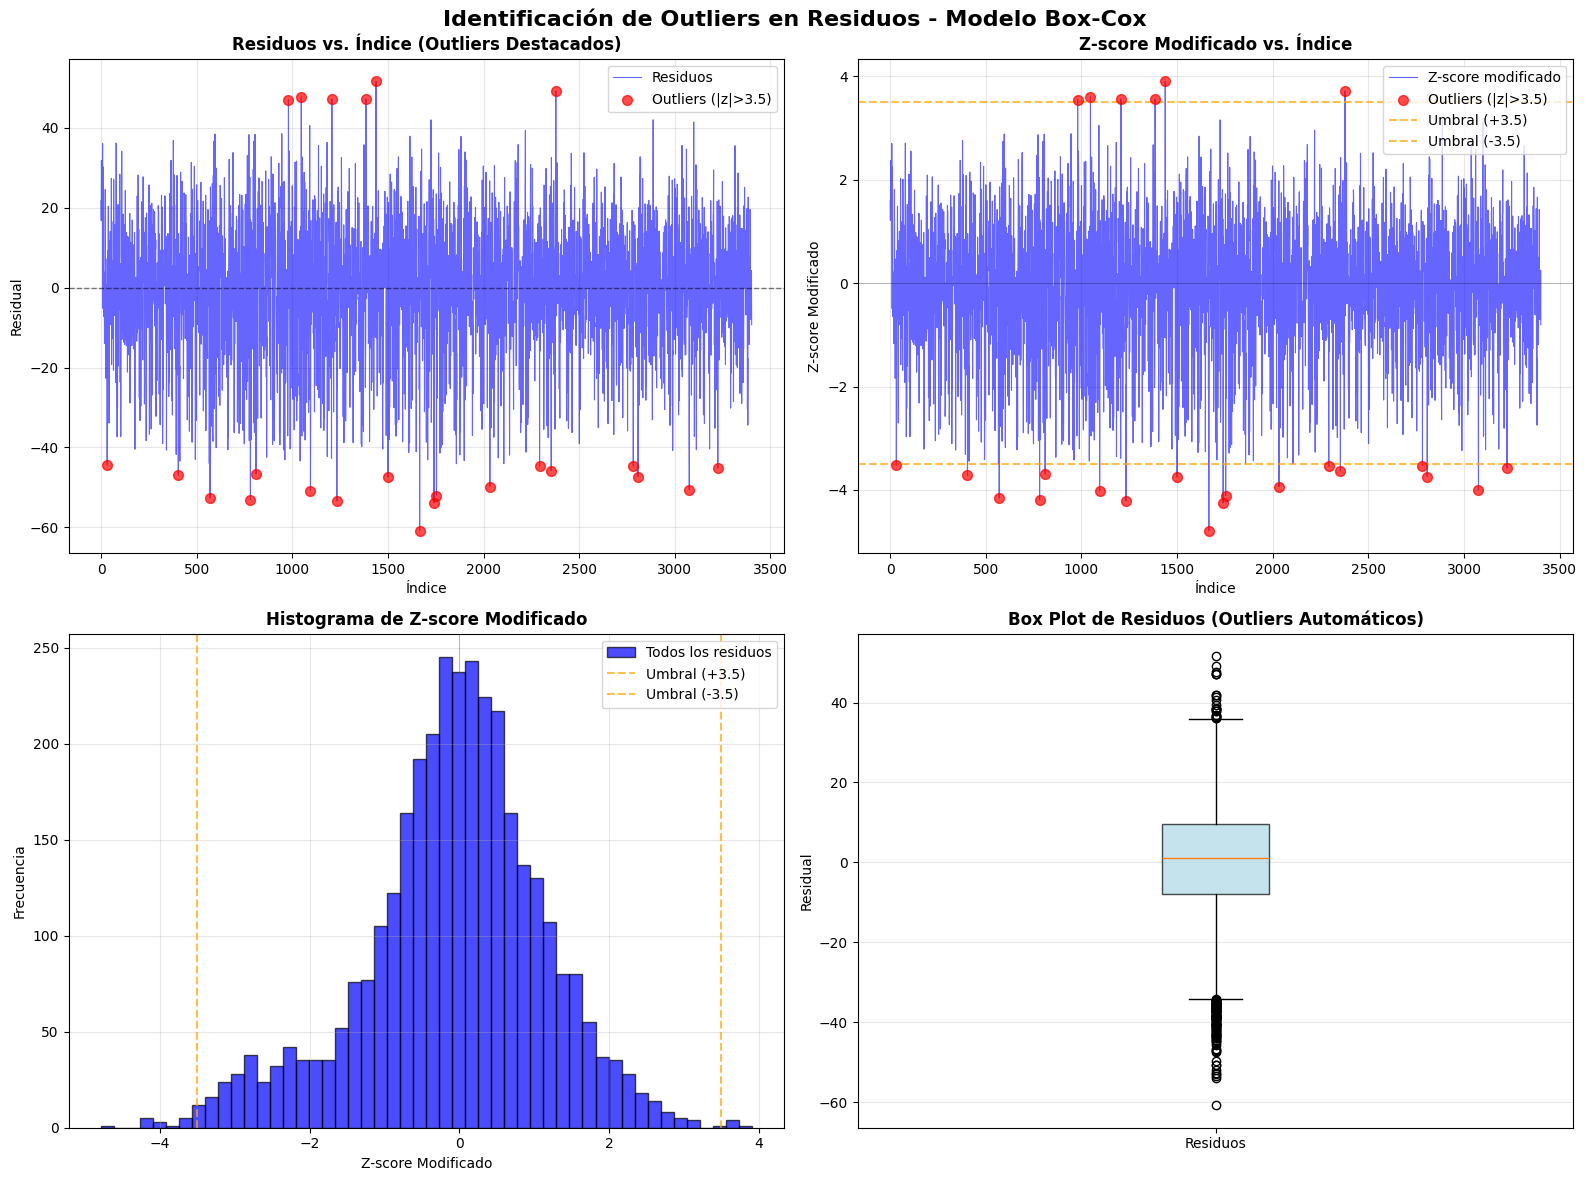


✅ IDENTIFICACIÓN DE OUTLIERS COMPLETADA

💡 Los índices de los outliers han sido guardados para uso futuro.
   Puedes usar estos índices para crear variables dummy en el futuro.


In [16]:
# ========== IDENTIFICACIÓN DE OUTLIERS EN RESIDUOS (MÉTODO Z-SCORE MODIFICADO) ==========

# Extraer residuos del modelo Box-Cox
residuals_boxcox = auto_arima_model_boxcox.arima_res_.resid

# Convertir a array numpy si es necesario y eliminar NaN/Inf
residuals_array = np.array(residuals_boxcox)
residuals_array = residuals_array[np.isfinite(residuals_array)]

# Crear DataFrame con residuos e índices
residuals_df = pd.DataFrame({
    'index': range(len(residuals_array)),
    'residual': residuals_array
})

print("=" * 70)
print("IDENTIFICACIÓN DE OUTLIERS EN RESIDUOS - MODELO BOX-COX")
print("=" * 70)
print(f"\n📊 Estadísticas básicas de los residuos:")
print(f"   - Total de observaciones: {len(residuals_array)}")
print(f"   - Media: {residuals_array.mean():.6f}")
print(f"   - Mediana: {np.median(residuals_array):.6f}")
print(f"   - Desviación estándar: {residuals_array.std():.6f}")
print(f"   - Mínimo: {residuals_array.min():.6f}")
print(f"   - Máximo: {residuals_array.max():.6f}")

# ========== CÁLCULO DE Z-SCORE MODIFICADO (MAD) ==========
# El método MAD es más robusto que el Z-score estándar porque usa la mediana
# en lugar de la media, lo que lo hace menos sensible a outliers

median_residual = np.median(residuals_array)
mad = np.median(np.abs(residuals_array - median_residual))

# Evitar división por cero
if mad == 0:
    mad = np.finfo(float).eps

# Calcular Z-score modificado
# El factor 0.6745 hace que MAD sea consistente con la desviación estándar para datos normales
modified_z_score = 0.6745 * (residuals_array - median_residual) / mad

# Agregar Z-score modificado al DataFrame
residuals_df['modified_z_score'] = modified_z_score
residuals_df['abs_modified_z_score'] = np.abs(modified_z_score)

print(f"\n📈 Estadísticas del Z-score modificado (MAD):")
print(f"   - Mediana de residuos: {median_residual:.6f}")
print(f"   - MAD (Median Absolute Deviation): {mad:.6f}")
print(f"   - Z-score modificado mínimo: {modified_z_score.min():.6f}")
print(f"   - Z-score modificado máximo: {modified_z_score.max():.6f}")
print(f"   - Z-score modificado medio (absoluto): {np.abs(modified_z_score).mean():.6f}")

# ========== IDENTIFICACIÓN DE OUTLIERS ==========
# Umbral estándar para outliers extremos: |modified_z| > 3.5
threshold = 3.5

outliers_mask = np.abs(modified_z_score) > threshold
outliers_df = residuals_df[outliers_mask].copy()

# Clasificar outliers en positivos y negativos
outliers_positive = outliers_df[outliers_df['modified_z_score'] > 0].copy()
outliers_negative = outliers_df[outliers_df['modified_z_score'] < 0].copy()

# Ordenar por valor absoluto del Z-score (los más destacados primero)
outliers_df_sorted = outliers_df.sort_values('abs_modified_z_score', ascending=False)

print(f"\n🔍 IDENTIFICACIÓN DE OUTLIERS (umbral: |modified_z| > {threshold}):")
print(f"   - Total de outliers identificados: {len(outliers_df)}")
print(f"   - Porcentaje de outliers: {100 * len(outliers_df) / len(residuals_array):.2f}%")
print(f"   - Outliers positivos: {len(outliers_positive)}")
print(f"   - Outliers negativos: {len(outliers_negative)}")

# ========== TABLA RESUMEN DE OUTLIERS MÁS DESTACADOS ==========
if len(outliers_df) > 0:
    print(f"\n📋 TOP 20 OUTLIERS MÁS DESTACADOS (por |Z-score modificado|):")
    print("=" * 70)
    top_outliers = outliers_df_sorted.head(20)
    display_df = top_outliers[['index', 'residual', 'modified_z_score', 'abs_modified_z_score']].copy()
    display_df.columns = ['Índice', 'Residual', 'Z-score Modificado', '|Z-score Modificado|']
    display_df['Índice'] = display_df['Índice'].astype(int)
    display_df = display_df.round(6)
    print(display_df.to_string(index=False))
    
    # Guardar índices de outliers para uso futuro (creación de dummies)
    outlier_indices = outliers_df_sorted['index'].values.astype(int).tolist()
    print(f"\n💾 Índices de todos los outliers (para uso futuro en dummies):")
    print(f"   Total: {len(outlier_indices)} índices")
    if len(outlier_indices) > 0:
        print(f"   Primeros 10: {outlier_indices[:10]}")
        if len(outlier_indices) > 10:
            print(f"   Últimos 10: {outlier_indices[-10:]}")
    
    # ========== ESTADÍSTICAS DESCRIPTIVAS DE OUTLIERS ==========
    print(f"\n📊 Estadísticas descriptivas de los OUTLIERS:")
    print(f"   - Media de residuos (outliers): {outliers_df['residual'].mean():.6f}")
    print(f"   - Mediana de residuos (outliers): {outliers_df['residual'].median():.6f}")
    print(f"   - Desviación estándar (outliers): {outliers_df['residual'].std():.6f}")
    print(f"   - Mínimo residual (outliers): {outliers_df['residual'].min():.6f}")
    print(f"   - Máximo residual (outliers): {outliers_df['residual'].max():.6f}")
    print(f"   - Media |Z-score modificado| (outliers): {outliers_df['abs_modified_z_score'].mean():.6f}")
    print(f"   - Máximo |Z-score modificado|: {outliers_df['abs_modified_z_score'].max():.6f}")
else:
    print(f"\n⚠️  No se encontraron outliers con el umbral |modified_z| > {threshold}")
    print(f"   Considera ajustar el umbral si esperabas encontrar outliers.")
    outlier_indices = []

# ========== VISUALIZACIONES ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Identificación de Outliers en Residuos - Modelo Box-Cox', fontsize=16, fontweight='bold')

# 1. Residuos vs. Tiempo con outliers destacados (arriba-izquierda)
axes[0, 0].plot(residuals_df['index'], residuals_df['residual'], 
                color='blue', linewidth=0.8, alpha=0.6, label='Residuos')
if len(outliers_df) > 0:
    axes[0, 0].scatter(outliers_df['index'], outliers_df['residual'], 
                      color='red', s=50, alpha=0.7, zorder=5, label=f'Outliers (|z|>{threshold})')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].set_title('Residuos vs. Índice (Outliers Destacados)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Z-score modificado vs. Índice (arriba-derecha)
axes[0, 1].plot(residuals_df['index'], residuals_df['modified_z_score'], 
               color='blue', linewidth=0.8, alpha=0.6, label='Z-score modificado')
if len(outliers_df) > 0:
    axes[0, 1].scatter(outliers_df['index'], outliers_df['modified_z_score'], 
                      color='red', s=50, alpha=0.7, zorder=5, label=f'Outliers (|z|>{threshold})')
axes[0, 1].axhline(y=threshold, color='orange', linestyle='--', linewidth=1.5, 
                   label=f'Umbral (+{threshold})', alpha=0.7)
axes[0, 1].axhline(y=-threshold, color='orange', linestyle='--', linewidth=1.5, 
                   label=f'Umbral (-{threshold})', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0, 1].set_title('Z-score Modificado vs. Índice', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Índice')
axes[0, 1].set_ylabel('Z-score Modificado')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Histograma de Z-score modificado (abajo-izquierda)
axes[1, 0].hist(residuals_df['modified_z_score'], bins=50, edgecolor='black', 
               alpha=0.7, color='blue', label='Todos los residuos')
axes[1, 0].axvline(x=threshold, color='orange', linestyle='--', linewidth=1.5, 
                  label=f'Umbral (+{threshold})', alpha=0.7)
axes[1, 0].axvline(x=-threshold, color='orange', linestyle='--', linewidth=1.5, 
                  label=f'Umbral (-{threshold})', alpha=0.7)
axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1, 0].set_title('Histograma de Z-score Modificado', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Z-score Modificado')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot de residuos con outliers (abajo-derecha)
box_data = [residuals_df['residual'].values]
bp = axes[1, 1].boxplot(box_data, vert=True, patch_artist=True, 
                       showfliers=True, labels=['Residuos'])
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_alpha(0.7)
axes[1, 1].set_title('Box Plot de Residuos (Outliers Automáticos)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Residual')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ IDENTIFICACIÓN DE OUTLIERS COMPLETADA")
print("=" * 70)
print(f"\n💡 Los índices de los outliers han sido guardados para uso futuro.")
print(f"   Puedes usar estos índices para crear variables dummy en el futuro.")


ANÁLISIS TEMPORAL DE OUTLIERS - MAPEO A FECHAS

📅 INFORMACIÓN TEMPORAL DE LOS OUTLIERS:
   - Total de outliers con fechas: 24

📋 TOP 20 OUTLIERS CON SUS FECHAS (ordenados por |Z-score|):
     fecha  año mes_nombre    brand   supermarket   residual  abs_modified_z_score
2022-06-30 2022       June brand-35 supermarket-A -60.784705              4.786592
2022-07-31 2022       July brand-35 supermarket-A -53.856402              4.250894
2022-01-31 2022    January brand-35 supermarket-A -53.372497              4.213478
2021-09-30 2021  September brand-35 supermarket-A -53.053385              4.188805
2021-06-30 2021       June brand-35 supermarket-A -52.700175              4.161494
2022-07-31 2022       July brand-15 supermarket-C -52.044196              4.110774
2021-12-31 2021   December brand-14 supermarket-C -50.790371              4.013828
2023-09-30 2023  September brand-35 supermarket-B -50.614836              4.000256
2022-10-31 2022    October brand-35 supermarket-A -49.824000      

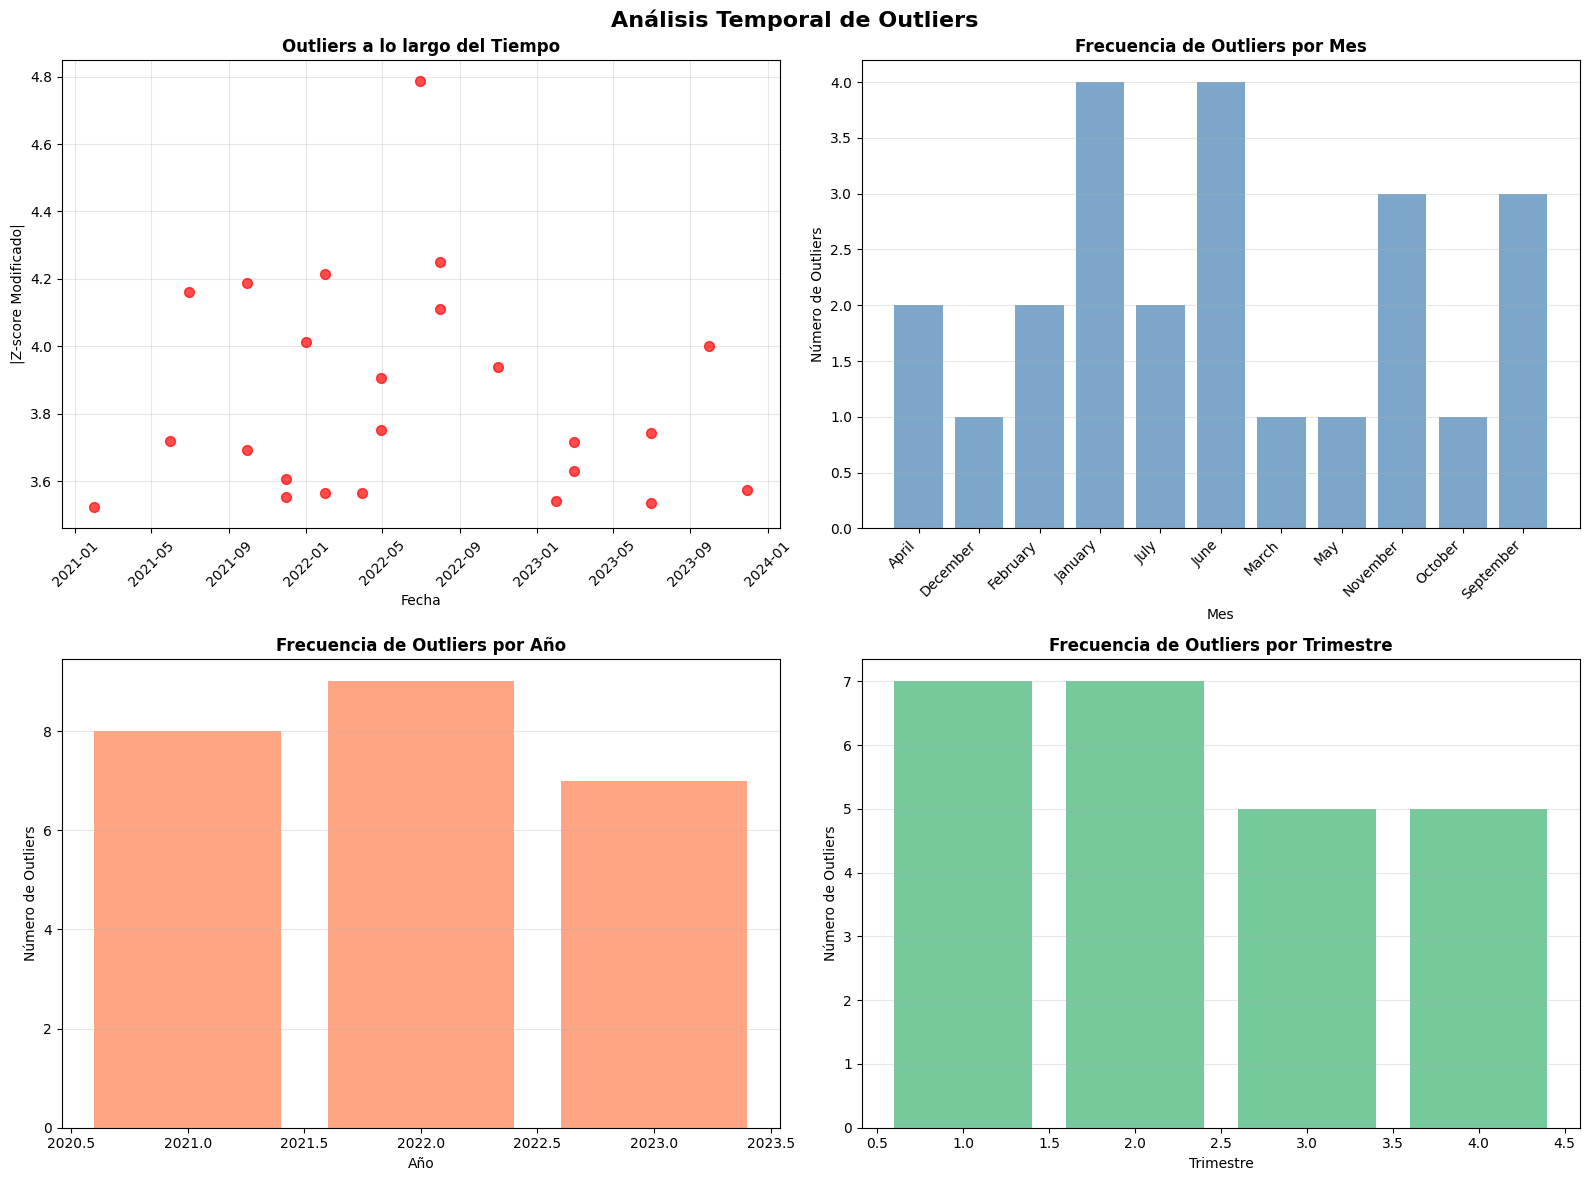


✅ ANÁLISIS TEMPORAL COMPLETADO


In [17]:
# ========== MAPEO DE OUTLIERS A FECHAS Y ANÁLISIS TEMPORAL ==========

if len(outlier_indices) > 0:
    print("=" * 70)
    print("ANÁLISIS TEMPORAL DE OUTLIERS - MAPEO A FECHAS")
    print("=" * 70)
    
    # Los índices de outliers corresponden a las posiciones en el array de residuos
    # que a su vez corresponden a las filas del DataFrame original 'data'
    # Necesitamos mapear estos índices a las fechas reales
    
    # Verificar si 'data' tiene columna 'date'
    if 'date' in data.columns:
        # Crear DataFrame con información de outliers y fechas
        outliers_with_dates = []
        
        for idx in outlier_indices:
            if idx < len(data):
                row_data = data.iloc[idx].copy()
                outlier_info = {
                    'indice_original': idx,
                    'fecha': row_data.get('date', 'N/A'),
                    'residual': residuals_array[idx],
                    'modified_z_score': modified_z_score[idx],
                    'abs_modified_z_score': abs(modified_z_score[idx]),
                    'volume_sales': row_data.get('volume.sales', 'N/A'),
                    'brand': row_data.get('brand', 'N/A'),
                    'supermarket': row_data.get('supermarket', 'N/A'),
                    'variant': row_data.get('variant', 'N/A'),
                    'pack_size': row_data.get('pack.size', 'N/A'),
                    'price': row_data.get('price', 'N/A')
                }
                outliers_with_dates.append(outlier_info)
        
        outliers_dates_df = pd.DataFrame(outliers_with_dates)
        
        # Convertir fecha a datetime si es posible
        if 'fecha' in outliers_dates_df.columns:
            try:
                outliers_dates_df['fecha'] = pd.to_datetime(outliers_dates_df['fecha'], errors='coerce')
                outliers_dates_df = outliers_dates_df.dropna(subset=['fecha'])
            except:
                pass
        
        # Extraer información temporal
        if 'fecha' in outliers_dates_df.columns and pd.api.types.is_datetime64_any_dtype(outliers_dates_df['fecha']):
            outliers_dates_df['año'] = outliers_dates_df['fecha'].dt.year
            outliers_dates_df['mes'] = outliers_dates_df['fecha'].dt.month
            outliers_dates_df['mes_nombre'] = outliers_dates_df['fecha'].dt.strftime('%B')
            outliers_dates_df['año_mes'] = outliers_dates_df['fecha'].dt.to_period('M')
            outliers_dates_df['trimestre'] = outliers_dates_df['fecha'].dt.quarter
            outliers_dates_df['dia_semana'] = outliers_dates_df['fecha'].dt.dayofweek
            outliers_dates_df['dia_semana_nombre'] = outliers_dates_df['fecha'].dt.strftime('%A')
        
        print(f"\n📅 INFORMACIÓN TEMPORAL DE LOS OUTLIERS:")
        print(f"   - Total de outliers con fechas: {len(outliers_dates_df)}")
        
        if len(outliers_dates_df) > 0:
            # Mostrar tabla con top outliers y sus fechas
            print(f"\n📋 TOP 20 OUTLIERS CON SUS FECHAS (ordenados por |Z-score|):")
            print("=" * 100)
            display_cols = ['fecha', 'año', 'mes_nombre', 'brand', 'supermarket', 'residual', 'abs_modified_z_score']
            display_cols = [col for col in display_cols if col in outliers_dates_df.columns]
            top_outliers_dates = outliers_dates_df.nlargest(20, 'abs_modified_z_score')[display_cols].copy()
            print(top_outliers_dates.to_string(index=False))
            
            # Análisis de frecuencia por mes
            if 'mes_nombre' in outliers_dates_df.columns:
                print(f"\n📊 FRECUENCIA DE OUTLIERS POR MES:")
                print("=" * 70)
                freq_mes = outliers_dates_df['mes_nombre'].value_counts().sort_index()
                for mes, count in freq_mes.items():
                    porcentaje = 100 * count / len(outliers_dates_df)
                    print(f"   {mes:15s}: {count:3d} outliers ({porcentaje:5.2f}%)")
            
            # Análisis de frecuencia por año
            if 'año' in outliers_dates_df.columns:
                print(f"\n📊 FRECUENCIA DE OUTLIERS POR AÑO:")
                print("=" * 70)
                freq_año = outliers_dates_df['año'].value_counts().sort_index()
                for año, count in freq_año.items():
                    porcentaje = 100 * count / len(outliers_dates_df)
                    print(f"   {año}: {count:3d} outliers ({porcentaje:5.2f}%)")
            
            # Análisis de frecuencia por trimestre
            if 'trimestre' in outliers_dates_df.columns:
                print(f"\n📊 FRECUENCIA DE OUTLIERS POR TRIMESTRE:")
                print("=" * 70)
                freq_trim = outliers_dates_df['trimestre'].value_counts().sort_index()
                for trim, count in freq_trim.items():
                    porcentaje = 100 * count / len(outliers_dates_df)
                    print(f"   Q{trim}: {count:3d} outliers ({porcentaje:5.2f}%)")
            
            # Análisis por brand
            if 'brand' in outliers_dates_df.columns:
                print(f"\n📊 FRECUENCIA DE OUTLIERS POR BRAND:")
                print("=" * 70)
                freq_brand = outliers_dates_df['brand'].value_counts()
                for brand, count in freq_brand.items():
                    porcentaje = 100 * count / len(outliers_dates_df)
                    print(f"   {brand:15s}: {count:3d} outliers ({porcentaje:5.2f}%)")
            
            # Análisis por supermarket
            if 'supermarket' in outliers_dates_df.columns:
                print(f"\n📊 FRECUENCIA DE OUTLIERS POR SUPERMARKET:")
                print("=" * 70)
                freq_super = outliers_dates_df['supermarket'].value_counts()
                for super, count in freq_super.items():
                    porcentaje = 100 * count / len(outliers_dates_df)
                    print(f"   {super:15s}: {count:3d} outliers ({porcentaje:5.2f}%)")
            
            # Rango de fechas
            if 'fecha' in outliers_dates_df.columns and pd.api.types.is_datetime64_any_dtype(outliers_dates_df['fecha']):
                print(f"\n📅 RANGO TEMPORAL DE LOS OUTLIERS:")
                print("=" * 70)
                print(f"   Fecha más antigua: {outliers_dates_df['fecha'].min()}")
                print(f"   Fecha más reciente: {outliers_dates_df['fecha'].max()}")
                print(f"   Rango temporal: {(outliers_dates_df['fecha'].max() - outliers_dates_df['fecha'].min()).days} días")
            
            # ========== SUGERENCIAS PARA VARIABLES DUMMY ==========
            print(f"\n💡 SUGERENCIAS PARA VARIABLES DUMMY:")
            print("=" * 70)
            
            suggestions = []
            
            # 1. Dummy por fecha específica (si hay concentración en fechas específicas)
            if 'fecha' in outliers_dates_df.columns and pd.api.types.is_datetime64_any_dtype(outliers_dates_df['fecha']):
                fecha_counts = outliers_dates_df['fecha'].value_counts()
                fechas_frecuentes = fecha_counts[fecha_counts > 1]
                if len(fechas_frecuentes) > 0:
                    suggestions.append(f"   - Dummy por fecha específica: {len(fechas_frecuentes)} fechas tienen múltiples outliers")
                    suggestions.append(f"     Fechas más frecuentes: {fechas_frecuentes.head(5).to_dict()}")
            
            # 2. Dummy por mes (si hay concentración mensual)
            if 'mes' in outliers_dates_df.columns:
                mes_counts = outliers_dates_df['mes'].value_counts()
                meses_destacados = mes_counts[mes_counts >= len(outliers_dates_df) * 0.1]  # Meses con >10% de outliers
                if len(meses_destacados) > 0:
                    suggestions.append(f"   - Dummy por mes: {len(meses_destacados)} meses concentran >10% de outliers cada uno")
                    suggestions.append(f"     Meses destacados: {meses_destacados.to_dict()}")
            
            # 3. Dummy por trimestre (si hay concentración trimestral)
            if 'trimestre' in outliers_dates_df.columns:
                trim_counts = outliers_dates_df['trimestre'].value_counts()
                trim_destacados = trim_counts[trim_counts >= len(outliers_dates_df) * 0.2]  # Trimestres con >20% de outliers
                if len(trim_destacados) > 0:
                    suggestions.append(f"   - Dummy por trimestre: {len(trim_destacados)} trimestres concentran >20% de outliers")
                    suggestions.append(f"     Trimestres destacados: {trim_destacados.to_dict()}")
            
            # 4. Dummy por año (si hay concentración anual)
            if 'año' in outliers_dates_df.columns:
                año_counts = outliers_dates_df['año'].value_counts()
                años_destacados = año_counts[año_counts >= len(outliers_dates_df) * 0.2]  # Años con >20% de outliers
                if len(años_destacados) > 0:
                    suggestions.append(f"   - Dummy por año: {len(años_destacados)} años concentran >20% de outliers")
                    suggestions.append(f"     Años destacados: {años_destacados.to_dict()}")
            
            # 5. Dummy por brand (si hay concentración por brand)
            if 'brand' in outliers_dates_df.columns:
                brand_counts = outliers_dates_df['brand'].value_counts()
                brands_destacados = brand_counts[brand_counts >= len(outliers_dates_df) * 0.2]
                if len(brands_destacados) > 0:
                    suggestions.append(f"   - Dummy por brand (outliers): {len(brands_destacados)} brands concentran >20% de outliers")
            
            # 6. Dummy binaria simple (si hay pocos outliers)
            if len(outlier_indices) < 50:
                suggestions.append(f"   - Dummy binaria simple: 'is_outlier' (1 si es outlier, 0 si no)")
                suggestions.append(f"     Total de outliers: {len(outlier_indices)} ({100*len(outlier_indices)/len(residuals_array):.2f}% del total)")
            
            if len(suggestions) > 0:
                for suggestion in suggestions:
                    print(suggestion)
            else:
                print("   - Considera crear una dummy binaria simple 'is_outlier' para todas las observaciones identificadas")
            
            # Guardar DataFrame con outliers y fechas para uso futuro
            print(f"\n💾 DataFrame 'outliers_dates_df' guardado con información completa de outliers y fechas")
            print(f"   Puedes usar este DataFrame para crear las variables dummy en el futuro")
            
            # ========== VISUALIZACIONES TEMPORALES ==========
            if 'fecha' in outliers_dates_df.columns and pd.api.types.is_datetime64_any_dtype(outliers_dates_df['fecha']):
                fig, axes = plt.subplots(2, 2, figsize=(16, 12))
                fig.suptitle('Análisis Temporal de Outliers', fontsize=16, fontweight='bold')
                
                # 1. Outliers a lo largo del tiempo (arriba-izquierda)
                axes[0, 0].scatter(outliers_dates_df['fecha'], outliers_dates_df['abs_modified_z_score'], 
                                 color='red', s=50, alpha=0.7, zorder=5)
                axes[0, 0].set_title('Outliers a lo largo del Tiempo', fontsize=12, fontweight='bold')
                axes[0, 0].set_xlabel('Fecha')
                axes[0, 0].set_ylabel('|Z-score Modificado|')
                axes[0, 0].grid(True, alpha=0.3)
                axes[0, 0].tick_params(axis='x', rotation=45)
                
                # 2. Frecuencia por mes (arriba-derecha)
                if 'mes_nombre' in outliers_dates_df.columns:
                    freq_mes = outliers_dates_df['mes_nombre'].value_counts().sort_index()
                    axes[0, 1].bar(range(len(freq_mes)), freq_mes.values, color='steelblue', alpha=0.7)
                    axes[0, 1].set_xticks(range(len(freq_mes)))
                    axes[0, 1].set_xticklabels(freq_mes.index, rotation=45, ha='right')
                    axes[0, 1].set_title('Frecuencia de Outliers por Mes', fontsize=12, fontweight='bold')
                    axes[0, 1].set_xlabel('Mes')
                    axes[0, 1].set_ylabel('Número de Outliers')
                    axes[0, 1].grid(True, alpha=0.3, axis='y')
                
                # 3. Frecuencia por año (abajo-izquierda)
                if 'año' in outliers_dates_df.columns:
                    freq_año = outliers_dates_df['año'].value_counts().sort_index()
                    axes[1, 0].bar(freq_año.index, freq_año.values, color='coral', alpha=0.7)
                    axes[1, 0].set_title('Frecuencia de Outliers por Año', fontsize=12, fontweight='bold')
                    axes[1, 0].set_xlabel('Año')
                    axes[1, 0].set_ylabel('Número de Outliers')
                    axes[1, 0].grid(True, alpha=0.3, axis='y')
                
                # 4. Frecuencia por trimestre (abajo-derecha)
                if 'trimestre' in outliers_dates_df.columns:
                    freq_trim = outliers_dates_df['trimestre'].value_counts().sort_index()
                    axes[1, 1].bar(freq_trim.index, freq_trim.values, color='mediumseagreen', alpha=0.7)
                    axes[1, 1].set_title('Frecuencia de Outliers por Trimestre', fontsize=12, fontweight='bold')
                    axes[1, 1].set_xlabel('Trimestre')
                    axes[1, 1].set_ylabel('Número de Outliers')
                    axes[1, 1].grid(True, alpha=0.3, axis='y')
                
                plt.tight_layout()
                plt.show()
        
        print("\n" + "=" * 70)
        print("✅ ANÁLISIS TEMPORAL COMPLETADO")
        print("=" * 70)
    else:
        print("\n⚠️  El DataFrame 'data' no tiene columna 'date'.")
        print("   No se puede realizar el análisis temporal de fechas.")
        print("   Los índices de outliers están disponibles en 'outlier_indices'")
else:
    print("\n⚠️  No hay outliers identificados para analizar temporalmente.")
